In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import (bipartite, centrality, community, clustering, link_prediction,
                                 distance_measures)
from networkx.drawing.layout import bipartite_layout
from networkx.classes.function import degree_histogram, density, subgraph, common_neighbors

import queue, heapq

import clingo

from fpgrowth import *

# == COMMUNITY ANALYTICS ===========================================================================
def intra_edges(graph, c):
    """
    the number of intra_edges of community C
    """
    amount_intra_edges = 0
    for node in c:
        for neighbor in graph.neighbors(node):
            if neighbor in c:
                amount_intra_edges += 1
    
    # in an undirected graph, each edge is counted twice
    return (amount_intra_edges / 2)            

def inter_edges(graph, c):
    """
    the number of inter_edges of community C
    """
    amount_inter_edges = 0
    for node in c:
        for neighbor in graph.neighbors(node):
            if not neighbor in c:
                amount_inter_edges += 1
    
    return amount_inter_edges

def inter_degree(graph, u, c):
    """
    inter-degree for a node u in community C
    """
    amount_inter_degree = 0
    for neighbor in graph.neighbors(u):
        if not neighbor in c:
            amount_inter_degree = 0
    
    return amount_inter_degree

def inverse_average_odf(graph, c):
    """
    inverse average out-degree fraction
    compares the number of inter-edges to the number of all edges of a community C
    and averages this for the wohle community by considering the fraction for each individual node
    """
    iaodf = 1 - (1 / len(c))
    sum = 0
    for node in c:
        deg = graph.degree(node)
        inter_deg = inter_degree(graph, node, c)
        sum += inter_deg / deg
    
    return iaodf * sum

def oe_iaodf(graph, c):
    """
    optimistic estimate of IAODF(C)
    """
    pass

def segregation_index(graph, c):
    """
    compares the number of expected inter-edges to the number of observed inter-edges
    normalized by the expectation
    """
    sidx = 1
    n = graph.number_of_nodes()
    m = graph.number_of_edges()
    nom = inter_edges(graph, c) * n * (n - 1)
    den = 2 * m * len(c) * (n - len(c))

    return sidx - (nom / den)

def oe_sidx(graph, c):
    """
    optimistic estimate of SIDX(C)
    """
    n = graph.number_of_nodes()
    m = graph.numner_of_edges()

    sidx = 1 - ((n * (n - 1)) / 2 * m)
    p = (n * n) / 4
    if len(c) < n / 2:
        p = len(c) * (n - len(c))

    max = 0
    for node in c:
        pass


def modularity(graph, comm):
    """
    modularity of a graph clustering with k communities focuses on the number of edges within a community
    compares that with the xpected such number given a null-model
    """
    return community.modularity(graph, comm)

def modularity_contribution(graph, c):
    """
    modularity contribution of a single community c in a local context (subgraph)
    """
    m = graph.number_of_edges()
    intra = intra_edges(graph, c)
    sum = 0
    for u in c:
        for v in c:
            sum += (graph.degree(u) * graph.degree(v)) / (4 * m * m)
    
    return (intra / m) - sum

def oe_modl(graph, c):
    """
    optimistice estimate of MODL(C)
    """
    m_c = intra_edges(graph, c)
    m = graph.number_of_edges()
    oe = 0.25
    if m_c < m / 2:
        oe = (m_c / m) - (m_c*m_c / m*m)
    
    return oe


# == COMMUNITY DETECTION ===========================================================================
# COMODO
class DataRecord:
    def __init__(self, edge):
        self.edge = edge
        self.common_attributes = []
        
        self.first_node = None
        self.first_degree = 0
        
        self.second_node = None
        self.second_degree = 0
    
    def setFirstNode(self, node, degree):
        self.first_node = node
        self.first_degree = degree

    def setSecondNode(self, node, degree):
        self.second_node = node
        self.second_degree = degree

    def setCommonAttributes(self, attributes):
        self.common_attributes = attributes

def comodo(graph, k, max_pattern_length, min_community_size, oe_number):
    db = transform(graph)
    cpt, headerTable = create_cpt(db, min_community_size) # initial community pattern tree
    top_k = [] # heapq priority queue
    print(headerTable[list(headerTable.keys())[0]][1].itemName)
    # comodo_mine(cpt, headerTable, [], top_k, k, max_pattern_length, min_community_size, oe_number, 0)

    # return (top_k, headerTable)
    # return max_pattern_size smallest elements from top_k

def transform(graph):
    """
    preprocessing the graph / database
    """
    data_records = []
    attributes = ["publisher", "alignment", "group_affiliation", "relatives", "work_base"]
    degrees = graph.degree()
    for edge in graph.edges:
        dr = DataRecord(edge)
        dr.setFirstNode(edge[0], degrees[edge[0]])
        dr.setSecondNode(edge[1], degrees(edge[1]))
        
        common_attributes = []
        for attr in attributes:
            attrs = nx.get_node_attributes(graph, attr)
            first_attrs = attrs[edge[0]]
            second_attrs = attrs[edge[1]]
            if first_attrs == "-" or second_attrs == "-":
                continue

            if not type(first_attrs) == str and len(first_attrs) > 1:
                for first in first_attrs:
                    if first in second_attrs:
                        common_attributes.append([first])
            elif first_attrs in second_attrs:
                common_attributes.append([first_attrs])

        dr.setCommonAttributes(common_attributes)
        
        data_records.append(dr)

    return data_records

def create_cpt(db, min_community_size):
    attribute_value_list = []
    for elem in db:
        attribute_value_list.extend(elem.common_attributes)

    frequency = getFrequencyFromList(attribute_value_list)
    cpt, headerTable = constructTree(attribute_value_list, frequency, 0)
    return (cpt, headerTable)

def comodo_mine(cpt, headerTable, pattern, top_k, k, max_pattern_length, min_community_size, oe_number, iteration):
    """
    branch & bouond algorithm based on an exhaustive subgroup discovery approach
    applies extended SD-Map* method
    similar to mineTree in fpgrowths utils.py
    """
    iteration += 1
    com = {} # basic-pattern -> pattern
    min_q = 0
    if not len(top_k) == 0:
        min_q = top_k[0][0]

    for basic_pattern in headerTable.keys(): # for all basic_patterns
        p = createRefinement(pattern, basic_pattern) # extending patterns
        com[basic_pattern] = p

        if size(p, headerTable) > min_community_size: # findPrefixPath
            qual = quality(p, oe_number, headerTable)
            if qual >= min_q:
                if len(top_k) + 1 > k:
                    # make sure to only keep track of the top k patterns
                    heapq.heappushpop(top_k, (qual, p))
                else:
                    heapq.heappush(top_k, (qual, p))

                min_q = top_k[0][0]

    if len(pattern) + 1 < max_pattern_length:
        refinements  = sortBasicPatternsByOptimisticEstimateDescending(com, oe_number)
        
        for oe, basic_pattern in refinements:
            if oe >= min_q:
                ccpt, c_headerTable = getConditionalCPT(basic_pattern, cpt, min_q) # basically another constructTree
                comodo_mine(ccpt, c_headerTable, com[basic_pattern], top_k, k, max_pattern_length, min_community_size, oe_number, iteration)

def createRefinement(pattern, basic_pattern):
    # copy pattern to new list to not change input pattern
    new_pattern = []
    for p in pattern:
        new_pattern.extend(p)

    # extending pattern
    if not basic_pattern in new_pattern:
        new_pattern.extend(basic_pattern)
    return new_pattern

def size(p, headerTable):
    node = headerTable[p][1]
    pattern_path, frequency = findPrefixPath(p, headerTable)
    return (pattern_path, frequency)

def quality(p, oe_number, headerTable):
    if oe_number == 0:
        return segregation_index(p)
    elif oe_number == 1:
        return inverse_average_odf(p)
    elif oe_number == 2:
        return modularity_contribution(p)
    return -1

def sortBasicPatternsByOptimisticEstimateDescending(com, oe_number):
    community_list = list(com.values())
    oe_list = []
    for idx, community in enumerate(community_list):
        oe = optimisticEstimate(community, oe_number)
        oe_list.append(oe)
        community_list[idx] = (oe, community)

    return sorted(community_list, key=lambda tup: tup[0], reverse=True)

def optimisticEstimate(com, oe_number):
    if oe_number == 0:
        return oe_sidx(com)
    elif oe_number == 1:
        return oe_iaodf(com)
    elif oe_number == 2:
        return oe_modl(com)
    return -1

def getConditionalCPT(basic_pattern, headerTable, min_q):
    conditional_pattern, frequency = findPrefixPath(basic_pattern, headerTable, min_q)
    ccpt, c_headerTable = constructTree(conditional_pattern, frequency, min_q)

    return (ccpt, c_headerTable)

# MINERLSD
def minerLSD(graph):
    """
    integrates abstract closed pattern mining with efficient pruning approaches
    not implemented due to time
    """
    pass

# == CLUSTERING COEFFICIENTS =======================================================================
def clustering_coefficient(graph, nodes=None):
    return clustering(graph, nodes)

# == SIMPLE GRAPHS ANALYTICS =======================================================================
def diameter(graph):
    return distance_measures.diameter(graph)

def degreeAnalysis(graph):
    non_connected = 0
    avg_degree = 0
    max_degree = 0
    all_count = 0
    degrees = nx.degree(graph)
    for node in graph.nodes:
        all_count += 1
        deg = degrees[node]
        if deg == 0:
            non_connected += 1
        else:
            if deg > max_degree:
                max_degree = deg
        avg_degree += deg

    print("#N: ", all_count, ", AVG_Degree: ", (avg_degree/all_count), ", #Non-Connected: ", non_connected)

# == CENTRALITIES ==================================================================================
def betweenness(graph):
    return centrality.betweenness_centrality(graph)

def closeness(graph, u=None):
    return centrality.closeness_centrality(graph, u)

def eigen(graph):
    try:
        result = centrality.eigenvector_centrality(graph)
    except Exception as e:
        print("ERROR IN EIGENVECTOR CENTRALITY", e)
        return False

    return result

# == NODE SIMILARITIES =============================================================================
def neighborhood_sim(graph, u, v):
    count = 1
    if graph.degree(u) == graph.degree(v):
        for n in graph.neighbors(u):
            if n == v:
                continue
            for m in graph.neighbors(v):
                if m == u:
                    continue
                if n == m:
                    count += 1

    return (count == graph.degree(u) and count == graph.degree(v))

def distance_sim(graph, u, v):
    pass

def structued_sim(graph, u, v):
    pass

# == LINK PREDICTION ===============================================================================
# note that all link prediction methods below and their clingo programs are based on and taken from REFERENZ ATZMUELLER

def bipartite_cold_start_link_prediction(graph, number_common_neighbors):
    """
    Turns a bipartite graph into a unipartite graph using Clingo

    Use number_common_neighbors to determine how many common neighbors two nodes should have
    to be connected by a link (here, how many common comic appearances should two characters have)
    """
    # setup clingo program
    control = clingo.Control()

    node_dict = {}
    node_number = 0
    # map node names to numbers and setup node facts
    node_types = nx.get_node_attributes(graph, "node_type")
    for node in graph.nodes:
        if not node in node_dict:
            node_dict[node] = node_number
            node_number += 1

        if node_types[node] == "hero":
            control.add("comic", [], "hero(" + str(node_dict[node]) + ").")
        else:
            control.add("comic", [], "comic(" + str(node_dict[node]) + ").")

    # setup edge facts
    for edge in graph.edges:
        control.add("comic", [], "edge(" + str(node_dict[edge[0]]) + "," + str(node_dict[edge[1]]) + ").")

    # setup rules
    control.add("comic", [], "edge(X,Y) :- edge(Y,X).")
    
    # is X common neighbor of Y and Z without an edge between them
    control.add("comic", [], "c(X,Y,Z) :- comic(X), hero(Y), hero(Z), edge(X,Y), edge(X,Z), not edge(Y,Z), Y!=Z.")

    # if two nodes have one common attribute_neighbor, predict link
    control.add("comic", [], "cn_lp(Y,Z) :- hero(Y), hero(Z), not edge(Y,Z), " + str(number_common_neighbors) + "=#count{X:c(X,Y,Z)}.")

    control.ground([("comic", [])])

    def on_model(m):
        """
        Retrieve the link prediction atoms ("cn_lp") and create new edges based off of them
        """
        count = 0
        node_keys = list(node_dict.keys())
        node_values = list(node_dict.values())
        for atom in m.symbols(atoms=True):
            if "cn_lp" in str(atom):
                left_node = int(str(atom).split("(")[1].split(",")[0])
                right_node = int(str(atom).split(",")[1].split(")")[0])
                graph.add_edge(node_keys[node_values.index(left_node)], node_keys[node_values.index(right_node)])
                count += 1
        print("Bipartite cold start: ", int(count / 2), " edges added.")

    control.solve(on_model=on_model)
    control.cleanup()


def attributed_cold_start_link_prediction(graph, include_publisher):
    """
    Solves the cold start link prediction problem for an attributed graph using Clingo
    """
    # setup clingo program
    control = clingo.Control()
    
    node_attributes = ["work_base", "group_affiliation"]
    if include_publisher:
        node_attributes = ["work_base", "group_affiliation", "publisher", "relatives"]
    
    attribute_dict = {}
    # preprocess attributes by mapping them to numbers
    number = -1 # choose negative numbers, since nodes have positive numbers
    for node in graph.nodes:
        for attr in node_attributes:
            all_nodes_attributes = nx.get_node_attributes(graph, attr)
            if not all_nodes_attributes[node] in attribute_dict and not all_nodes_attributes[node] == "-":
                attribute_dict[all_nodes_attributes[node]] = number
                number -= 1

    node_dict = {}
    node_number = 0
    # map node names to numbers and setup node facts
    for node in graph.nodes:
        if not node in node_dict:
            node_dict[node] = node_number
            node_number += 1

        node_to_add = "node(" + str(node_dict[node]) + ")."
        control.add("cold_start", [], node_to_add)

        # setup bipartite attribute graph
        node_attr_to_add = "node_attr(" + str(node_dict[node]) + ")."
        control.add("cold_start", [], node_attr_to_add)

        for attr in node_attributes:
            node_attrs = nx.get_node_attributes(graph, attr)
            # skip empty attribute
            if node_attrs[node] == "-":
                continue
            attribute_of_node = attribute_dict[node_attrs[node]]
            attr_to_add = "a(" + str(attribute_of_node) + ")."
            control.add("cold_start", [], attr_to_add)

            edge_node_attr_to_add = "edge_attr(" + str(node_dict[node]) + "," + str(attribute_of_node) + ")."
            control.add("cold_start", [], edge_node_attr_to_add)
        
        # node_node_info = nx.get_node_attributes(graph, "relatives")

    # setup edges
    for edge in graph.edges:
        edge_to_add = "edge(" + str(node_dict[edge[0]]) + "," + str(node_dict[edge[1]]) + ")."
        control.add("cold_start", [], edge_to_add)

    # setup rules
    # undirected edges
    control.add("cold_start", [], "edge(Y,X) :- edge(X,Y).")
    control.add("cold_start", [], "edge_attr(Y,X) :- edge_attr(X,Y).")

    # is X common neighbor of Y and Z without an edge between them
    control.add("cold_start", [], "c(X,Y,Z) :- edge(X,Y), edge(X,Z), not edge(Y,Z), Y!=Z.")
    control.add("cold_start", [], "c_attr(X,Y,Z) :- edge_attr(X,Y), edge_attr(X,Z), not edge_attr(Y,Z), Y!=Z.")

    # if two nodes have one common attribute_neighbor, predict link
    control.add("cold_start", [], "cn_lp(Y,Z) :- node_attr(Y), node_attr(Z), not edge_attr(Y,Z), 1=#count{X:c_attr(X,Y,Z)}.")

    control.ground([("cold_start", [])])

    def on_model(m):
        """
        Retrieve the link prediction atoms ("cn_lp") and create new edges based off of them
        """
        count = 0
        node_keys = list(node_dict.keys())
        node_values = list(node_dict.values())
        for atom in m.symbols(atoms=True):
            if "cn_lp" in str(atom):
                left_node = int(str(atom).split("(")[1].split(",")[0])
                right_node = int(str(atom).split(",")[1].split(")")[0])
                graph.add_edge(node_keys[node_values.index(left_node)], node_keys[node_values.index(right_node)])
                count += 1
        print("Attributed cold start: ", int(count / 2), " edges added.")

    control.solve(on_model=on_model)
    control.cleanup()


def structured_link_prediction(graph, number_common_neighbors):
    """
    Solves one iteration of link prediction of a graph based on its structure
    """
    # setup clingo program
    control = clingo.Control()

    node_dict = {}
    node_number = 0
    # map node names to numbers and setup node facts
    for node in graph.nodes:
        if not node in node_dict:
            node_dict[node] = node_number
            node_number += 1

        node_to_add = "node(" + str(node_dict[node]) + ")."
        control.add("struct_link_pred", [], node_to_add)

    # setup edges
    for edge in graph.edges:
        edge_to_add = "edge(" + str(node_dict[edge[0]]) + "," + str(node_dict[edge[1]]) + ")."
        control.add("struct_link_pred", [], edge_to_add)

    # setup rules
    # undirected edges
    control.add("struct_link_pred", [], "edge(Y,X) :- edge(X,Y).")

    # is X common neighbor of Y and Z without an edge between them
    control.add("struct_link_pred", [], "c(X,Y,Z) :- edge(X,Y), edge(X,Z), not edge(Y,Z), Y!=Z.")

    # if two nodes have two common neighbors, predict link
    control.add("struct_link_pred", [], "cn_lp(Y,Z) :- node(Y), node(Z), not edge(Y,Z), " + str(number_common_neighbors) + "=#count{X:c(X,Y,Z)}.")

    control.ground([("struct_link_pred", [])])

    def on_model(m):
        """
        Retrieve the link prediction atoms ("cn_lp") and create new edges based off of them
        """
        count = 0
        node_keys = list(node_dict.keys())
        node_values = list(node_dict.values())
        for atom in m.symbols(atoms=True):
            if "cn_lp" in str(atom):
                left_node = int(str(atom).split("(")[1].split(",")[0])
                right_node = int(str(atom).split(",")[1].split(")")[0])
                graph.add_edge(node_keys[node_values.index(left_node)], node_keys[node_values.index(right_node)])
                count += 1
        print("Structural link prediction: ", int(count / 2), " edges added.")

    control.solve(on_model=on_model)
    control.cleanup()

def external_structured_link_prediction(source_graph, target_graph):
    """
    Solves one iteration of link prediction of a graph based on the its own and the structure of another graph
    Information from the source_graph will help 'predict' links for the target graph
    """
    # setup clingo program
    control = clingo.Control()

    source_node_dict = {}
    source_node_number = 0
    # map node names to numbers and setup node facts
    for node in source_graph.nodes:
        if not node in source_node_dict:
            source_node_dict[node] = source_node_number
            source_node_number += 1

        node_to_add = "source_node(" + str(source_node_dict[node]) + ")."
        control.add("ext_link_pred", [], node_to_add)

    # setup edges
    for edge in source_graph.edges:
        edge_to_add = "source_edge(" + str(source_node_dict[edge[0]]) + "," + str(source_node_dict[edge[1]]) + ")."
        control.add("ext_link_pred", [], edge_to_add)

    target_node_dict = {}
    target_node_number = 0
    # map node names to numbers and setup node facts
    for node in target_graph.nodes:
        if not node in target_node_dict:
            target_node_dict[node] = target_node_number
            target_node_number += 1

        node_to_add = "target_node(" + str(target_node_dict[node]) + ")."
        control.add("ext_link_pred", [], node_to_add)

    # setup edges
    for edge in target_graph.edges:
        edge_to_add = "target_edge(" + str(target_node_dict[edge[0]]) + "," + str(target_node_dict[edge[1]]) + ")."
        control.add("ext_link_pred", [], edge_to_add)

    # setup rules
    # undirected edges
    control.add("ext_link_pred", [], "source_edge(Y,X) :- source_edge(X,Y).")
    control.add("ext_link_pred", [], "target_edge(Y,X) :- target_edge(X,Y).")

    class Context:
        def __init__(self, target_node_dict, source_node_dict):
            self.source_node_keys = list(source_node_dict.keys())
            self.source_node_values = list(source_node_dict.values())
            print("SOURCE: ", self.source_node_keys[self.source_node_values.index(0)])

            self.target_node_keys = list(target_node_dict.keys())
            self.target_node_values = list(target_node_dict.values())
            print("TARGET: ", self.target_node_keys[self.target_node_values.index(0)])

        def is_similar_node(self, x, y):
            """
            Function used to compare two nodes
            Function is used in Clingo programm

            Similarity is measured based on the nodes names
            X-target_node, Y-source_node
            
            returns True if the nodes are similar enough
            """
            x_name = self.target_node_keys[self.target_node_values.index(x)]
            y_name = self.source_node_keys[self.source_node_values.index(y)]
            if x_name in y_name or y_name in x_name:
                print("True: ", x_name, y_name)
                return x
            return y

    # if two similar nodes are connected in the source_graph, predict link in target_graph
    control.add("ext_link_pred", [], "ext_lp(X,Y) :- target_node(X), target_node(Y), not target_edge(X,Y), 1<=#count{W,V:source_node(W), source_node(V), source_edge(W,V), target_node(@is_similar_node(X,W)), target_node(@is_similar_node(Y,V))}.")

    control.ground([("ext_link_pred", [])], context=Context(target_node_dict, source_node_dict))

    def on_model(m):
        """
        Retrieve the link prediction atoms ("ext_lp") and create new edges based off of them
        """
        count = 0
        node_keys = list(target_node_dict.keys())
        node_values = list(target_node_dict.values())
        for atom in m.symbols(atoms=True):
            if "ext_lp" in str(atom):
                left_node = int(str(atom).split("(")[1].split(",")[0])
                right_node = int(str(atom).split(",")[1].split(")")[0])
                # target_graph.add_edge(node_keys[node_values.index(left_node)], node_keys[node_values.index(right_node)])
                count += 1
        print("External link prediction: ", int(count / 2), " edges added.")

    control.solve(on_model=on_model)
    control.cleanup()


In [40]:
# == LOAD DATA & PREPROCESSING =====================================================================
# (csv have been slightly adapted to be separated by ';' since some names include ',' already)

def load_graphs(comic):
    """
    load graphs from both datasets
    with simplify, the characters in both graphs can be adapted to be the same set of characters

    Args:
        simplify (bool): whether the resulting graphs should be simplified to only contain the same characters as nodes 

    Returns:
        _type_: marvel_graph, super_graph
    """
    # FIRST GRAPH - MarvelUniverse
    # (node, type)
    data_nodes = pd.read_csv("data/MarvelUniverse/nodes.csv", sep=";").reset_index()

    if comic:
        # (hero, comic) - probably not needed, see paper for explanation
        data_marvel_edges = pd.read_csv("data/MarvelUniverse/edges.csv", sep=";")
    else:
        # (hero1, hero2)
        data_marvel_edges = pd.read_csv("data/MarvelUniverse/hero-network.csv", sep=";")


    # SECOND GRAPH - SUPER HERO DATASET
    super_nodes = pd.read_csv("data/Heroes/data.csv")

    # drop all information/attributes not contributing to graph structure (decrease data size)
    attributes_to_drop = ["powerstats__intelligence", "powerstats__strength", "powerstats__speed"
                        ,"powerstats__durability", "powerstats__power", "powerstats__combat"
                        ,"biography__place-of-birth" ,"biography__first-appearance"
                        ,"appearance__gender", "appearance__race"
                        ,"appearance__height__001", "appearance__height__002"
                        ,"appearance__weight__001", "appearance__weight__002"
                        ,"appearance__eye-color", "appearance__hair-color", "work__occupation"]
    for i in range(2, 21):
        if i <= 9:
            attr_to_drop = "biography__aliases__00" + str(i)
        else:
            attr_to_drop = "biography__aliases__0" + str(i)
        attributes_to_drop.append(attr_to_drop)

    for col in attributes_to_drop:
        del super_nodes[col]

    super_nodes["name"] = super_nodes["name"].str.upper()
    super_nodes["biography__full-name"] = super_nodes["biography__full-name"].str.upper()
    super_nodes["connections__relatives"] = super_nodes["connections__relatives"].str.upper()

    marvel_nodes = data_nodes["node"][data_nodes["type"] == "hero"].unique().tolist()
    if comic:
        comic_nodes = data_nodes["node"][data_nodes["type"] == "comic"].unique().tolist()

    # == CREATE GRAPHS =================================================================================
    marvel_graph = nx.Graph()
    marvel_graph.add_nodes_from(marvel_nodes, node_type="hero")
    if comic:
        marvel_graph.add_nodes_from(comic_nodes, node_type="comic")

    marvel_edges = data_marvel_edges.values.tolist()
    marvel_edges = [tuple(x) for x in marvel_edges]
    marvel_graph.add_edges_from(marvel_edges)

    super_graph = nx.Graph()
    # add nodes with selection of attributes
    for idx, row in super_nodes.iterrows():
        super_graph.add_node(row["name"], work_base=row["work__base"],
                                          full_name=row["biography__full-name"],
                                          alter_egos=row["biography__alter-egos"],
                                          alias=row["biography__aliases__001"],
                                          publisher=row["biography__publisher"],
                                          alignment=row["biography__alignment"],
                                          group_affiliation=row["connections__group-affiliation"],
                                          relatives=row["connections__relatives"])

    return (marvel_graph, super_graph)

def simplify_marvel_graph(marvel_graph, super_graph):
    found = [False] * len(marvel_graph.nodes)
    full_names = nx.get_node_attributes(super_graph, "full_name")
    for super_node in super_graph.nodes:
        current_names = [super_node, full_names[super_node]]

        count = 0
        for marvel_node in marvel_graph.nodes:
            for curr_name in current_names:
                check = True
                if type(curr_name) == float:
                    continue
                if " " in curr_name:
                    # separate name in parts since in marvel_node e.g. first and last name could be swapped
                    name_in_parts = curr_name.split(" ")
                    check = True
                    for part in name_in_parts:
                        # complete name has to be found
                        if not part in marvel_node:
                            check = False
                else:
                    if not curr_name in marvel_node:
                        check = False
                
                if check:
                    # print(marvel_node, "<>", curr_name)
                    found[count] = True
                
            count += 1
    
    removed = 0
    to_be_removed = []
    for idx, node in enumerate(marvel_graph.nodes):
        if not found[idx]:
            removed += 1
            to_be_removed.append(node)

    marvel_graph.remove_nodes_from(to_be_removed)

    print(removed, " nodes in Marvel_Graph deleted.")

def delete_comic_nodes(graph):
    to_be_removed = []
    node_types = nx.get_node_attributes(graph, "node_type")
    for node in graph:
        if node_types[node] == "comic":
            to_be_removed.append(node)

    graph.remove_nodes_from(to_be_removed)
        

In [138]:
# == LINK PREDICTION ====================================================================
use_comics_graph = [True]#, False]
use_publisher = [True, False]
bipartite_common_comics = [2, 5, 10, 20]
number_common_neighbors = [2, 3, 5, 10, 20]
oe_numbers = [0, 1, 2]
for use_comics in use_comics_graph:

    for common_comics in bipartite_common_comics:

        for number_neighbors in number_common_neighbors:

            for publisher in use_publisher:

                for oe_number in oe_numbers:
                    marvel_graph, super_graph = load_graphs(use_comics)

                    bipartite_cold_start_link_prediction(marvel_graph, common_comics)
                    delete_comic_nodes(marvel_graph)
                    
                    # if not use_comics:
                    #     simplify_marvel_graph(marvel_graph, super_graph)

                    # super hero graph
                    attributed_cold_start_link_prediction(super_graph, publisher)

                    super_predicted = 1
                    marvel_predicted = 1
                    count = 0
                    while not super_predicted == 0 or not marvel_predicted == 0 and count < 5:
                        if not super_predicted == 0:
                            super_predicted = structured_link_prediction(super_graph, number_neighbors)
                        if not marvel_predicted == 0:
                            marvel_predicted = structured_link_prediction(marvel_graph, number_neighbors)
                        count += 1

                    external_structured_link_prediction(marvel_graph, super_graph)

                    marvel_communities = community.greedy_modularity_communities(marvel_graph)
                    super_communities = comodo(super_graph, len(marvel_communities), 10, 0, oe_number)


Bipartite cold start:  5355  edges added.
Attributed cold start:  239  edges added.
SOURCE:  24-HOUR MAN/EMMANUEL
TARGET:  A-BOMB


ValueError: Number(0) is not in list

In [73]:
# # == CREATE IPARTITE GRAPH ==================================================================
# bipartite_graph = nx.Graph()

# comic_nodes = data_nodes["node"][data_nodes["type"] == "comic"].unique().tolist()

# edges_tuple = [tuple(x) for x in data_comic_edges.values.tolist()]

# bipartite_graph.add_nodes_from(comic_nodes, bipartite=0)
# bipartite_graph.add_nodes_from(hero_nodes, bipartite=1)

# bipartite_graph.add_edges_from(edges_tuple)

# top_nodes = {n for n, d in bipartite_graph.nodes(data=True) if d["bipartite"] == 0}
# bottom_nodes = set(bipartite_graph) - top_nodes

# # == VISUALIZE BIPARTITE GRAPH =====================================================================
# plt.figure(figsize=(200, 20))
# pos = bipartite_layout(bipartite_graph, top_nodes, align="horizontal")
# color_dict = {0: "blue", 1:"red"}
# color_list = [color_dict[i[1]] for i in bipartite_graph.nodes.data("bipartite")]
# nx.draw(bipartite_graph, pos=pos, node_size=10, with_labels=False, node_color=color_list)
# plt.show()


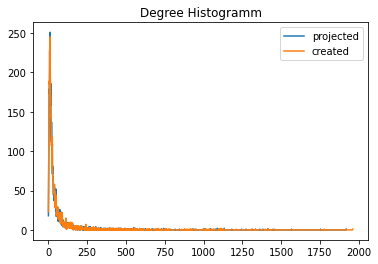

DENSIITY
Projected:  0.00828112280415326
Created:  0.00822201029483371
DIAMETER


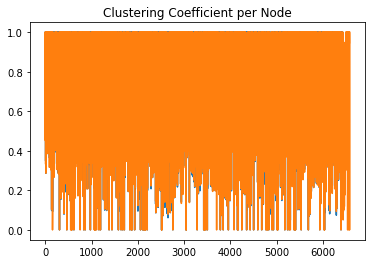

In [26]:
# == GRAPH COMPARISON ==============================================================================

# degree histogramms
marvel_degrees = degree_histogram(marvel_graph)
super_degrees = degree_histogram(super_graph)

plt.plot(marvel_degrees, label="projected")
plt.plot(super_degrees, label="created")
plt.title("Degree Histogramm")
plt.legend()
plt.show()
plt.close()

# density
print("DENSIITY")
print("Projected: ", density(marvel_graph))
print("Created: ", density(super_graph))

# diameter
print("DIAMETER")
if nx.is_connected(marvel_graph):
    print("Projected: ", diameter(marvel_graph))
if nx.is_connected(super_graph):
    print("Created: ", diameter(super_graph))

# clustering coefficients
marvel_clustering = list(clustering_coefficient(marvel_graph).values())
super_clustering = list(clustering_coefficient(super_graph).values())

plt.plot(marvel_clustering, label="MarvelUniverse")
plt.plot(super_clustering, label="SuperHeroes")
plt.title("Clustering Coefficient per Node")
plt.show()
plt.close()

# centralities
# marvel_betweenness = list(betweenness(marvel_graph).values())
# super_betweenness = list(betweenness(super_graph).values())

# plt.plot(marvel_betweenness, label="MarvelUniverse")
# plt.plot(super_betweenness, label="SuperHeroes")
# plt.title("Betweenness Centrality per Node")
# plt.show()
# plt.close()

# marvel_closeness = list(closeness(marvel_graph).values())
# super_closeness = list(closeness(super_graph).values())

# plt.plot(marvel_graph_closeness, label="MarvelUniverse")
# plt.plot(super_closeness, label="SuperHeroes")
# plt.title("Closeness Centrality per Node")
# plt.show()
# plt.close()

# marvel_eigen = list(eigen(marvel_graph).values())
# super_eigen = list(eigen(super_graph).values())

# plt.plot(marvel_eigen, label="MarvelUniverse")
# plt.plot(super_eigen, label="SuperHeroes")
# plt.title("Eigenvector Centrality per Node")
# plt.show()
# plt.close()


In [ ]:
# == COMMUNITY DETECTION ===========================================================================
# comodo(marvel_graph)
# comodo(super_graph)

minerLSD(marvel_graph)
minerLSD(super_graph)

# == GRAPH VISUALIZATION ===========================================================================

In [ ]:
# == LINK PREDICTION ===============================================================================

In [ ]:
# == 2ND GRAPH COMPARISON ==========================================================================
# degree histogramms
marvel_degrees = degree_histogram(marvel_graph)
super_degrees = degree_histogram(super_graph)

plt.plot(marvel_degrees, label="projected")
plt.plot(super_degrees, label="created")
plt.title("Degree Histogramm")
plt.legend()
plt.show()

# density
print("DENSIITY")
print("Projected: ", density(marvel_graph))
print("Created: ", density(super_graph))

# diameter
print("DIAMETER")
if nx.is_connected(marvel_graph):
    print("Projected: ", diameter(marvel_graph))
if nx.is_connected(super_graph):
    print("Created: ", diameter(super_graph))

# clustering coefficients
marvel_clustering = list(clustering_coefficient(marvel_graph).values())
super_clustering = list(clustering_coefficient(super_graph).values())

plt.plot(marvel_clustering, label="MarvelUniverse")
plt.plot(super_clustering, label="SuperHeroes")
plt.title("Clustering Coefficient per Node")
plt.show()

# centralities
# marvel_betweenness = list(betweenness(marvel_graph).values())
# super_betweenness = list(betweenness(super_graph).values())

# plt.plot(marvel_betweenness, label="MarvelUniverse")
# plt.plot(super_betweenness, label="SuperHeroes")
# plt.title("Betweenness Centrality per Node")
# plt.show()

# marvel_closeness = list(closeness(marvel_graph).values())
# super_closeness = list(closeness(super_graph).values())

# plt.plot(marvel_graph_closeness, label="MarvelUniverse")
# plt.plot(super_closeness, label="SuperHeroes")
# plt.title("Closeness Centrality per Node")
# plt.show()

# marvel_eigen = list(eigen(marvel_graph).values())
# super_eigen = list(eigen(super_graph).values())

# plt.plot(marvel_eigen, label="MarvelUniverse")
# plt.plot(super_eigen, label="SuperHeroes")
# plt.title("Eigenvector Centrality per Node")
# plt.show()

In [ ]:
# == 2ND COMMUNITY DETECTION =======================================================================
# comodo(marvel_graph)
# comodo(super_graph)

minerLSD(marvel_graph)
minerLSD(super_graph)

# == GRAPH VISUALIZATION ===========================================================================